In [126]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.prompts import ChatPromptTemplate , FewShotChatMessagePromptTemplate


In [16]:
from dotenv import load_dotenv

In [21]:
%cd ..

/home/mohamed/Documents/GitHub/Invoice-OCR


In [4]:
llm = ChatGoogleGenerativeAI(
    model = "gemini-flash-latest",
    temperature=0

)

In [110]:
from langchain_core.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field
from typing import List ,Optional


class InvoiceItem(BaseModel):
    description: str = Field(..., description="The description of the item")
    tax_amount: Optional[float] = Field(..., description="Taxes applied to this item")
    quantity: Optional[float] 
    unit_price: Optional[float] 
    total: Optional[float] 


class InvoiceData(BaseModel):
    buyer_name: str = Field(..., description="Name of the buyer on the invoice")
    invoice_date: str = Field(..., description="Date of the invoice")
    items: List[InvoiceItem] = Field(..., description="List of items in the invoice")


parser = PydanticOutputParser(pydantic_object=InvoiceData)


In [121]:
import base64

def read_image_base64(image_path):
    with open(image_path ,"rb") as img_data:
        img_base64 = base64.b64encode(img_data.read()).decode("utf-8")

    return img_base64    

In [123]:
examples = [{
    "invoice_img": read_image_base64("data/FACTU2018050056.jpg"),
    "invoice_data": InvoiceData(

    buyer_name="Lumber Lnc",

    invoice_date="15-05-2018",

    items=[

        InvoiceItem(

            description="Bureau d'angle assis à droite ",
            tax_amount=0.2,
            quantity=69.00,
            unit_price =600.00,
            total=41400.00

        ),
        InvoiceItem(

            description="Armoire avec portes  ",
            tax_amount=0.1,
            quantity=92.00,
            unit_price =120.00,
            total=11086.00

        ),
        InvoiceItem(

            description="Architecte Principal (Facturation sur Feuilles de Temps)",
            tax_amount=0.2,
            quantity=99.00,
            unit_price =150.00,
            total=14850.00

        ),
        InvoiceItem(

            description="Assemblage de Cuisine (Étapes Importantes) ",
            tax_amount=0.2,
            quantity=65.00,
            unit_price =420.00,
            total= 27300.00

        ),
        InvoiceItem(

            description="Poubelle à pédale ",
            tax_amount=0.1,
            quantity=69.00,
            unit_price =10.00,
            total=690.00

        ),
        InvoiceItem(

            description="Boîte de rangement ",
            tax_amount=0.2,
            quantity=81.00,
            unit_price =14.00,
            total=1134.00

        )
        

    ]).model_dump_json()
    

}]

In [127]:
example_few_shot =ChatPromptTemplate.from_messages([
       {
        "role": "user",
        "content": [
            {
                "type": "image",
                "source_type": "base64",
                "data":" {invoice_img}",
                "mime_type": "image/jpeg"
            }
        ]
    },
    (
        "assistant","{invoice_data}"
    )
])

few_shot_prompet = FewShotChatMessagePromptTemplate(
    example_prompt= example_few_shot,
    examples= examples
)

In [ ]:
few_shot_prompet.invoke({}).to_messages()

In [142]:
from langchain_core.prompts import ChatPromptTemplate

masg = ChatPromptTemplate.from_messages([
    ("system", """
        Extract data from this invoice.
        Follow this output schema: {output_schema}
    """),
    few_shot_prompet,
    {
        "role": "user",
        "content": [
            {
                "type": "input_image",
                "image_url": "data:image/jpeg;base64,{image_data}"
            }
        ]
    }
]).partial(output_schema=parser.get_format_instructions())

In [143]:
pipeline= masg | llm |parser

In [146]:
def get_invoice_data(path_image):
    img_b64 = read_image_base64(path_image)
    output = pipeline.invoke({
    "image_data":img_b64,})

    return output

In [165]:
out=get_invoice_data("data/FACTU2019010033.jpg")

In [166]:
out.items

[InvoiceItem(description='Tiroir', tax_amount=0.0, quantity=31.0, unit_price=100.0, total=3100.0),
 InvoiceItem(description='Canapé trois places', tax_amount=0.2, quantity=12.0, unit_price=1000.0, total=12000.0),
 InvoiceItem(description='Architecte Junior (Facturation sur Feuilles de Temps)', tax_amount=0.2, quantity=70.0, unit_price=85.0, total=5950.0),
 InvoiceItem(description='Grande table de réunion', tax_amount=0.2, quantity=26.0, unit_price=4500.0, total=117000.0),
 InvoiceItem(description='Architecte Principal (Facturation sur Feuilles de Temps)', tax_amount=0.2, quantity=61.0, unit_price=150.0, total=9150.0),
 InvoiceItem(description='Écrans ant-bruit', tax_amount=0.0, quantity=20.0, unit_price=287.0, total=5740.0),
 InvoiceItem(description='Poubelle à pédale', tax_amount=0.2, quantity=55.0, unit_price=10.0, total=550.0)]

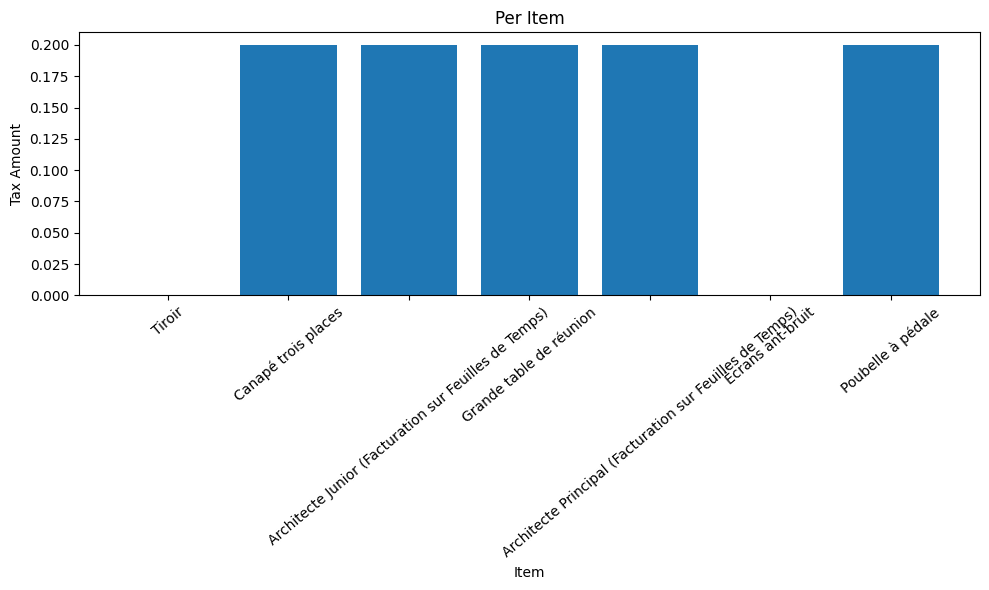

In [174]:
import matplotlib.pyplot as plt

items = out.items

names = [item.description for item in items]
tax_values = [item.tax_amount if item.tax_amount is not None else 0 for item in items]

plt.figure(figsize=(10,6))
plt.bar(names, tax_values)
plt.xlabel("Item")
plt.ylabel("Tax Amount")
plt.title("Per Item")
plt.xticks(rotation=40)
plt.tight_layout()
plt.show()


In [171]:
res=llm.invoke("قلي نقطه مصريه")

In [172]:
res.content

[{'type': 'text',
  'text': 'مرة مدرس بيسأل طالب: "مين اللي اكتشف أمريكا؟"\n\nالطالب قاله: "والله يا أستاذ مش أنا!" 😂</blockquote>',
  'extras': {'signature': 'CrwSAXLI2nw9FvFHJRrB1yNp+nSpwXZRVtEX8GfRWvbsVYrWVLjBK1RcJ+cHb4sjeC68WMnKidfD69Ef9AgvJFhRf/iLg+Ulg0sLUHfn7hz9IsO0kE/dhXPO06d/m3fz3Ff2H0d2a/yT1Jm6J7t0YaT1gImEZftD+eviJXagFqIlBuOCB4B4jNYvMiKLP0xGzVM/beRxLGkRp5ZkWfcAIbrvmw8SHsh9R7U6W+Jw8AiT1y/MfsWAdsAAjuSrC4Xb7FA3cWTCGLKJ2Lw0T4JyhoIVlPhMs7w8aSkMoyHo1gZUXOJ1pOaeKS4QSxAXPTBafL9blY8zpyvhErFe6xwEdcMeiHxuxa+KFYgSicny+PA/54JwrIBYKtGE/W8TQmWCcfayPw/CfaNsqcTc6U/gdYyxCXp+c9zTuG5wXwugII9sHtfF2STo5U6+uOMcSXtALzT9zMaiTcXvW9CPho5APNfBFiq/u8eeQlXEkmoXlEPWHshWNPBpa0LzaDg7we+oS9IsmblR6gUosHWTRHyIxefuQIfHEqsR3Fvomkn+qbYf+GepkNQx1YmEBbNcD9glUahO3s9aN0u2I7qqCRE5tDz9y1JP2al37+lvoFnR9Mys6vLgkKyzM76PE0mVDj87nyqGSyuP/iNDfR+39FDLnc8qVCekuAAJofNHajUiaCXHId8dbtuR1bxZZB26MwWhqI/OSX1jM46KBnWQHfGdXavV3NQ3BtLVSFtUnCcDZqaHtQgwLtqWFlA0eehpWh+FfB1+L8DfDa5Wd4lC8ORzt5U29qRyCHhvl2RZAfyBThD+rULSFfJaN+LoHEuG3aB/AnvLEvJK